In [92]:
### 데이터 및 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
file = '../data/공정데이터 추가자료.csv'
data = pd.read_csv(file)

In [93]:
### 데이터 전처리
# 불필요 컬럼(Unnamed: 12 -> 데이터 값이 없거나 0) 제거
data = data.drop(columns=['time', 'Unnamed: 12'])


# 모든 설정값이 동일한 s_temp_sv와 c_temp_sv컬럼 제거
data = data.drop(columns=['s_temp_sv', 'c_temp_sv'])


# 2차 미팅 결과 E_scr_sv가 8이 아닌 다른 값으로 셋팅된 것은 다른 제품에 대한 셋팅값으로 판단, E_scr_sv 값이 8인 행만 남기기
data = data[data['E_scr_sv'] == 8]


# E_scr_sv 값이 모두 8이므로 학습에 변화량을 제공하지 않아 삭제
data = data.drop(columns=['E_scr_sv'])


# E_scr_sv 컬럼 삭제 후 확인 시 n_temp_sv 컬럼이 모두 같은 값으로 통일되었기에 해당 컬럼을 삭제
data = data.drop(columns=['n_temp_sv'])


# E_scr_pv 컬럼의 고유값 확인시 8과 0으로 나옴 -> E_scr_pv 값이 8인 경우와 0인 경우로 데이터 나누기
data_8 = data[data['E_scr_pv'] == 8]
data_0 = data[data['E_scr_pv'] == 0]


## E_scr_pv 값이 0인 경우 k_rpm_pv가 모두 0이고, scale_pv값이 0 또는 600이상 값으로만 나옴
# scale_pv 값이 600 이상인 행은 기준이 되는 3과 너무 큰 차이가 나므로 측정 오류로 판단, 모두 삭제
data = data[data['scale_pv'] < 600]


# scale_pv 값이 4 이상인 행 또한 측정 오류로 판단, 모두 삭제
data = data[data['scale_pv'] < 4]


# c_temp_pv 값이 혼자 65.1인 날 E_scr_pv, k_rpm_pv, scale_pv값이 모두 0이므로 삭제, 남은 c_temp_pv 값이 모두 68 이상이므로 c_temp_pv 값이 68 미만인 행 삭제
data = data[data['c_temp_pv'] >= 68]


# 실제 칼날 회전수로 파악하는 방식 결정, k_rpm_sv 컬럼 제거
data = data.drop(columns=['k_rpm_sv'])


# E_scr_pv값이 0인 모든 케이스가  k_rpm_sv값이 50미만에 포함, 해당 값들은 scale_pv도 대부분 0 이므로 제외 -> 남은 E_scr_pv 모두 8이라 의미가 없으므로 E_scr_pv 컬럼 제거
data = data.drop(columns=['E_scr_pv'])


# k_rpm_pv값이 50미만 값들은 타겟이 3g인 값들에 대한 k_rpm_pv값 차이가 커 오류로 판단, scale_pv 값이 50 미만인 행 삭제
data = data[data['k_rpm_pv'] >= 50]


# scale_pv값이 0 인 경우 미측정, 나머지 0 초과 2 이하의 경우 측정오류로 판단, 제거
data = data[(data['scale_pv'] == 0) | (data['scale_pv'] > 2)]

In [94]:
### 모델 생성을 위한 데이터 증강 by KNN
# scale_pv가 0이 아닌 데이터와 0인 데이터로 분리
non_zero_data = data[data['scale_pv'] != 0]
zero_data = data[data['scale_pv'] == 0]


# KNN을 위한 피처와 타겟 설정 (scale_pv가 0이 아닌 데이터)
features = non_zero_data.drop(columns=['scale_pv'])
target = non_zero_data['scale_pv']


# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_zero_features = scaler.transform(zero_data.drop(columns=['scale_pv']))


# KNN 모델 적합
knn = KNeighborsRegressor(n_neighbors=50) # 설정 이웃 수 2->1->5->10->100->50->25->50
knn.fit(scaled_features, target)


# 미측정 데이터에 대한 예측값 생성 (scale_pv가 0인 데이터, 소수점 아래 둘째자리까지)
predicted_scale_pv = np.round(knn.predict(scaled_zero_features), 2)


# 예측값을 미측정 데이터에 추가
zero_data.loc[:, 'scale_pv'] = predicted_scale_pv


# 원본 데이터와 새로 생성된 데이터를 결합하여 인덱스 기준으로 재정렬
data = pd.concat([non_zero_data, zero_data]).sort_index()
data = data.loc[data.index]

C:\Users\KDP\AppData\Local\Temp\ipykernel_12624\4266626108.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_data.loc[:, 'scale_pv'] = predicted_scale_pv


In [95]:
data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,69.6,189,67.2,3.0100,67.1
1,69.8,189,67.2,3.0100,67.0
2,69.7,189,67.9,3.0800,65.9
3,69.7,189,67.8,3.0800,65.9
4,69.7,189,67.8,3.0800,65.9
...,...,...,...,...,...
235407,69.7,191,67.6,3.0408,67.3
235408,69.8,191,67.5,3.0450,67.0
235409,69.7,191,67.4,3.0440,66.8
235410,69.7,191,67.3,3.0474,66.7


In [96]:
print(data['c_temp_pv'].describe(), data['n_temp_pv'].describe(), data['s_temp_pv'].describe())

count    227879.000000
mean         70.214447
std           0.527539
min          68.000000
25%          69.800000
50%          70.200000
75%          70.500000
max          71.900000
Name: c_temp_pv, dtype: float64 count    227879.000000
mean         67.793757
std           1.078624
min          65.700000
25%          67.000000
50%          67.400000
75%          68.500000
max          71.200000
Name: n_temp_pv, dtype: float64 count    227879.000000
mean         67.591881
std           1.248470
min          65.400000
25%          66.500000
50%          67.500000
75%          68.300000
max          72.400000
Name: s_temp_pv, dtype: float64


In [97]:
# 유사한 값을 선택할 범위 설정
tolerance = 0.2  # 적절한 범위 설정 필요

# 평균값 계산
c_temp_mean = data['c_temp_pv'].mean()
n_temp_mean = data['n_temp_pv'].mean()
s_temp_mean = data['s_temp_pv'].mean()

# 필터링 조건 설정
filtered_data = data[
    (data['c_temp_pv'].between(c_temp_mean - tolerance, c_temp_mean + tolerance)) &
    (data['n_temp_pv'].between(n_temp_mean - tolerance, n_temp_mean + tolerance)) &
    (data['s_temp_pv'].between(s_temp_mean - tolerance, s_temp_mean + tolerance))
]

In [98]:
filtered_data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
2989,70.1,176,67.7,3.0700,67.7
2990,70.2,176,67.8,3.0700,67.6
2991,70.2,176,67.8,3.0700,67.6
2992,70.1,176,67.8,3.0700,67.5
4366,70.3,179,67.6,3.1100,67.5
...,...,...,...,...,...
234503,70.2,188,67.7,3.0374,67.6
234674,70.2,189,67.6,3.0332,67.7
234675,70.1,189,67.7,3.0344,67.5
234676,70.1,189,67.7,3.0342,67.4


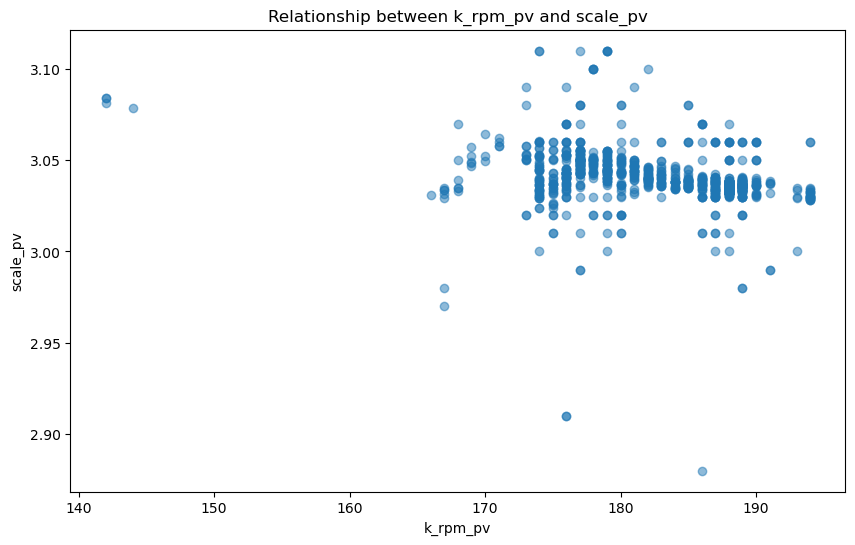

Correlation between k_rpm_pv and scale_pv: -0.2869620035539022


In [99]:
# 관계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['k_rpm_pv'], filtered_data['scale_pv'], alpha=0.5)
plt.xlabel('k_rpm_pv')
plt.ylabel('scale_pv')
plt.title('Relationship between k_rpm_pv and scale_pv')
plt.show()

# 상관관계 계산
correlation = filtered_data['k_rpm_pv'].corr(filtered_data['scale_pv'])
print(f'Correlation between k_rpm_pv and scale_pv: {correlation}')

C:\Users\KDP\AppData\Local\Temp\ipykernel_12624\886115170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['scale_pv_diff'] = filtered_data['scale_pv'].diff()
C:\Users\KDP\AppData\Local\Temp\ipykernel_12624\886115170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['k_rpm_pv_diff'] = filtered_data['k_rpm_pv'].diff()


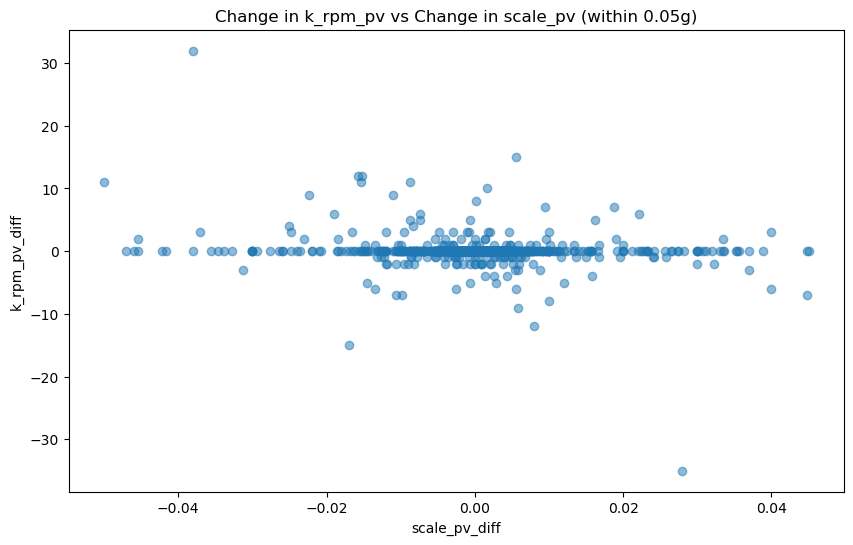

In [100]:
# scale_pv 0.05g 변동에 따른 k_rpm_pv 변화량 계산
filtered_data['scale_pv_diff'] = filtered_data['scale_pv'].diff()
filtered_data['k_rpm_pv_diff'] = filtered_data['k_rpm_pv'].diff()

# 특정 변동 범위 내 데이터 필터링
tolerance_diff = 0.05
subset_data = filtered_data[abs(filtered_data['scale_pv_diff']) <= tolerance_diff]

# 변동량 분석
plt.figure(figsize=(10, 6))
plt.scatter(subset_data['scale_pv_diff'], subset_data['k_rpm_pv_diff'], alpha=0.5)
plt.xlabel('scale_pv_diff')
plt.ylabel('k_rpm_pv_diff')
plt.title('Change in k_rpm_pv vs Change in scale_pv (within 0.05g)')
plt.show()

In [101]:
# 특정 변동 범위 내 데이터 필터링
tolerance_diff = 0.05
subset_data = filtered_data[abs(filtered_data['scale_pv_diff']) <= tolerance_diff].dropna()

# 회귀 분석을 위한 데이터 준비
X = subset_data['scale_pv_diff'].values.reshape(-1, 1)
y = subset_data['k_rpm_pv_diff'].values

# 회귀 분석 모델 생성 및 적합
regression_model = LinearRegression()
regression_model.fit(X, y)

# 회귀 분석 결과
slope = regression_model.coef_[0]
intercept = regression_model.intercept_

print(f'회귀 분석 결과: k_rpm_pv 변동량 = {slope:.4f} * scale_pv 변동량 + {intercept:.4f}')

회귀 분석 결과: k_rpm_pv 변동량 = -38.9796 * scale_pv 변동량 + 0.0333
